# Knn Clustering

1. Choose K (the number of clusters you want).

2. Initialize K centroids randomly.

3. Repeat until convergence:
   a. Assign each data point to the nearest centroid.
   b. Recalculate the centroids based on the current assignment of data points.
   
4. Return the final K centroids and the corresponding cluster assignments.


In [ ]:
# import modules 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 



In [57]:
df = pd.read_csv('../cleaning-preprocessing/cleaned_flight_data_with_target.csv')
df.head(5)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_M,CRS_ARR_M,Temperature,Dew Point,Humidity,...,Condition_Light Snow / Windy,Condition_Mostly Cloudy,Condition_Mostly Cloudy / Windy,Condition_Partly Cloudy,Condition_Partly Cloudy / Windy,Condition_Rain,Condition_Rain / Windy,Condition_Snow,Condition_Wintry Mix,Condition_Wintry Mix / Windy
0,11,1,5,124,636,324,448,48,34,58,...,False,False,False,False,False,False,False,False,False,False
1,11,1,5,371,2475,340,531,48,34,58,...,False,False,False,False,False,False,False,False,False,False
2,11,1,5,181,1069,301,482,48,34,58,...,False,False,False,False,False,False,False,False,False,False
3,11,1,5,168,944,345,513,48,34,58,...,False,False,False,False,False,False,False,False,False,False
4,11,1,5,139,760,360,499,46,32,58,...,False,False,False,False,False,False,False,False,False,False


In [58]:
X = df.drop(columns=['DEP_DELAY'])  # Feature matrix
# X_1 = df['MONTH','DAY_OF_MONTH','DAY_OF_WEEK','CRS_ELAPSED_TIME','DISTANCE','CRS_ARR_M','Temperature','Dew Point','Humidity','DEP_DELAY'] 
y = df['DEP_DELAY']  # Target variable

### Feature Selection

In [59]:
X = X.applymap(lambda x: max(x, 0))
X = X.fillna(X.mean())

/tmp/ipykernel_9170/3256436071.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: max(x, 0))


In [60]:
from sklearn.feature_selection import chi2, SelectKBest 
# Perform Chi-Square test 
chi2_selector = SelectKBest(score_func=chi2, k=12) 
X_selected = chi2_selector.fit_transform(X, y) # Get selected feature names 
selected_features = X.columns[chi2_selector.get_support()] 
print("Selected Features:", selected_features.tolist())

Selected Features: ['DAY_OF_MONTH', 'CRS_ELAPSED_TIME', 'DISTANCE', 'CRS_DEP_M', 'CRS_ARR_M', 'Dew Point', 'Humidity', 'Wind Gust', 'sch_dep', 'OP_UNIQUE_CARRIER_MQ', 'Condition_Light Freezing Rain', 'Condition_Light Snow / Windy']


In [61]:
chi2_scores = pd.Series(chi2_selector.scores_, index=X.columns)
sorted_chi2_scores = chi2_scores.sort_values(ascending=False) 
print(chi2_scores.sort_values(ascending=False))

DISTANCE                           406426.240345
CRS_DEP_M                          108835.588461
CRS_ARR_M                           93049.827231
CRS_ELAPSED_TIME                    43030.113811
Wind Gust                           13946.110023
                                       ...      
Condition_Light Drizzle / Windy        74.900652
DEST_OAK                               50.005753
Condition_Drizzle and Fog              28.609359
Condition_Snow                         21.279483
Pressure                                1.877004
Length: 110, dtype: float64


In [62]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size = 0.25, random_state = 0)

In [63]:
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler() 
X_train = sc.fit_transform(X_train) 
X_test = sc.transform(X_test)

In [64]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=2)

In [65]:
y_pred = neigh.predict(X_test)

In [66]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-Squared (R2): {r2:.4f}")


Model Performance Metrics:
Mean Squared Error (MSE): 1603.71
Mean Absolute Error (MAE): 14.01
R-Squared (R2): 0.1276


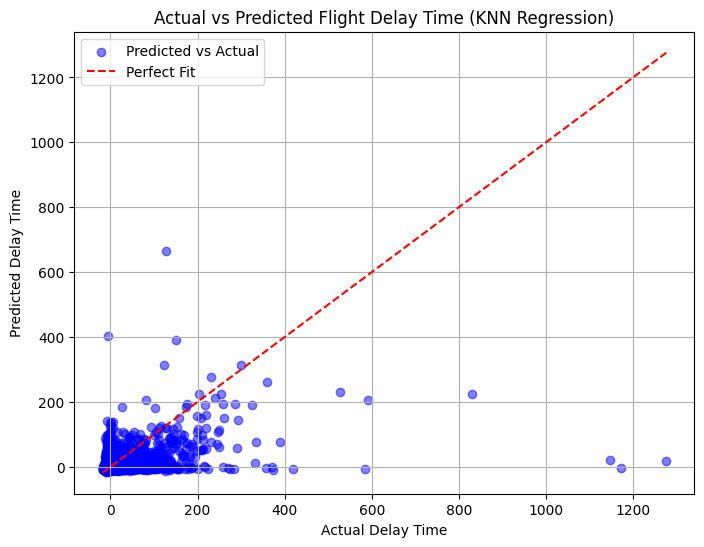

In [67]:
# Plot Actual vs. Predicted Prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Fit")

plt.xlabel("Actual Delay Time")
plt.ylabel("Predicted Delay Time")
plt.title("Actual vs Predicted Flight Delay Time (KNN Regression)")
plt.legend()
plt.grid(True)
plt.show()